In [2]:
import sys
import os

# 方法 1：使用 os.getcwd() 获取当前工作目录
current_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(current_dir, ".."))
print(f"add project root \"{project_root}\" to system path:")
sys.path.append(project_root)

add project root "/mnt/nas-data/work-data/programs/2025-03-14-fine-tune-clip" to system path:


初始化logger

In [3]:
from clip_tuner.utils import Logger

logger = Logger(log_dir="../logs/", log_file="train_demo.log", file_mode="w")
print(f"created logger at \"{logger.log_path}\"")

created logger at "/mnt/nas-data/work-data/programs/2025-03-14-fine-tune-clip/logs/train_demo.log"


构建Model Manager，管理模型，随后加载一个模型 "clip-vit-base-patch32"

In [4]:
from transformers import CLIPModel, CLIPTokenizer, CLIPImageProcessor
from clip_tuner.models import ModelManager

model_manager = ModelManager()
for model_info in model_manager.list_models():
    print(model_info)
model_info = model_manager.get_model("clip-vit-base-patch32")
clip_model = CLIPModel.from_pretrained(model_info.path)
clip_tokenizer = CLIPTokenizer.from_pretrained(model_info.path)
clip_image_processor = CLIPImageProcessor.from_pretrained(model_info.path)

clip_model, clip_tokenizer, clip_image_processor

Model: clip-vit-b-16-datacomp.l-s1b-b8k, Path: /mnt/nas-data/work-data/models/modelscope/hub/laion/CLIP-ViT-B-16-DataComp.L-s1B-b8K/, Config: 
Model: clip-vit-l-14-datacomp.xl-s13b-b90k, Path: /mnt/nas-data/work-data/models/modelscope/hub/laion/CLIP-ViT-L-14-DataComp.XL-s13B-b90K/, Config: 
Model: clip-vit-base-patch32, Path: /mnt/nas-data/work-data/models/modelscope/hub/thomas/clip-vit-base-patch32/, Config: 
Model: clip-vit-base-patch16, Path: /mnt/nas-data/work-data/models/modelscope/hub/openai-mirror/clip-vit-base-patch16/, Config: 


(CLIPModel(
   (text_model): CLIPTextTransformer(
     (embeddings): CLIPTextEmbeddings(
       (token_embedding): Embedding(49408, 512)
       (position_embedding): Embedding(77, 512)
     )
     (encoder): CLIPEncoder(
       (layers): ModuleList(
         (0-11): 12 x CLIPEncoderLayer(
           (self_attn): CLIPSdpaAttention(
             (k_proj): Linear(in_features=512, out_features=512, bias=True)
             (v_proj): Linear(in_features=512, out_features=512, bias=True)
             (q_proj): Linear(in_features=512, out_features=512, bias=True)
             (out_proj): Linear(in_features=512, out_features=512, bias=True)
           )
           (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
           (mlp): CLIPMLP(
             (activation_fn): QuickGELUActivation()
             (fc1): Linear(in_features=512, out_features=2048, bias=True)
             (fc2): Linear(in_features=2048, out_features=512, bias=True)
           )
           (layer_norm2): La

构建Data Manager，管理数据集，随后加载一个数据集 "office-31" - "webcam"

In [5]:
from datasets import load_dataset
from clip_tuner.data import DataManager, get_train_transforms, get_val_transforms

data_manager = DataManager(logger=None)  # build data manager without logger
for dataset in data_manager.list_datasets():
    print(dataset)

source_info = data_manager.get_dataset("office-31", "webcam")
target_info = data_manager.get_dataset("office-31", "amazon")

source_dataset = load_dataset(source_info.data_dir)["train"]
target_dataset = load_dataset(target_info.data_dir)["train"]

print(clip_image_processor.crop_size)

source_dataset.set_transform(get_train_transforms(image_size=(clip_image_processor.crop_size["height"], clip_image_processor.crop_size["width"]), image_mean=clip_image_processor.image_mean, image_std=clip_image_processor.image_std))
target_dataset.set_transform(get_val_transforms(image_size=(clip_image_processor.crop_size["height"], clip_image_processor.crop_size["width"]), image_mean=clip_image_processor.image_mean, image_std=clip_image_processor.image_std))

source_dataset, source_dataset.features["label"].names, target_dataset

DatasetInfo(dataset_name=office-31, domain_name=amazon, data_dir=/mnt/nas-data/work-data/datasets/images/office-31/amazon/images/, num_classes=31, class_names=['mouse', 'mobile_phone', 'printer', 'punchers', 'keyboard', 'tape_dispenser', 'bike', 'desktop_computer', 'trash_can', 'scissors', 'file_cabinet', 'projector', 'letter_tray', 'bottle', 'monitor', 'laptop_computer', 'calculator', 'phone', 'bookcase', 'ring_binder', 'headphones', 'speaker', 'desk_lamp', 'stapler', 'mug', 'pen', 'back_pack', 'desk_chair', 'ruler', 'bike_helmet', 'paper_notebook'])
DatasetInfo(dataset_name=office-31, domain_name=dslr, data_dir=/mnt/nas-data/work-data/datasets/images/office-31/dslr/images/, num_classes=31, class_names=['paper_notebook', 'ring_binder', 'pen', 'trash_can', 'mug', 'projector', 'speaker', 'bottle', 'ruler', 'bike', 'laptop_computer', 'stapler', 'bike_helmet', 'calculator', 'bookcase', 'desk_lamp', 'letter_tray', 'desktop_computer', 'monitor', 'headphones', 'mouse', 'desk_chair', 'file_ca

{'height': 224, 'width': 224}


(Dataset({
     features: ['image', 'label'],
     num_rows: 795
 }),
 ['back_pack',
  'bike',
  'bike_helmet',
  'bookcase',
  'bottle',
  'calculator',
  'desk_chair',
  'desk_lamp',
  'desktop_computer',
  'file_cabinet',
  'headphones',
  'keyboard',
  'laptop_computer',
  'letter_tray',
  'mobile_phone',
  'monitor',
  'mouse',
  'mug',
  'paper_notebook',
  'pen',
  'phone',
  'printer',
  'projector',
  'punchers',
  'ring_binder',
  'ruler',
  'scissors',
  'speaker',
  'stapler',
  'tape_dispenser',
  'trash_can'],
 Dataset({
     features: ['image', 'label'],
     num_rows: 2817
 }))

修改dataset，当前 dataset 的 label 字段为整数，
适配 image classification 任务，而非 zero-shot image classification

{'image': [<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=487x487 at 0x794470D099D0>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=613x613 at 0x794470D09820>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=427x427 at 0x794470D40770>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=311x311 at 0x794470D4C260>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=446x446 at 0x794470D4D460>], 'label': [12, 22, 2, 4, 22]}


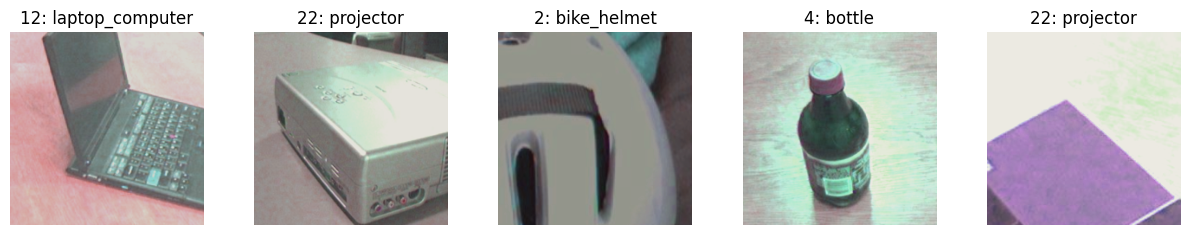

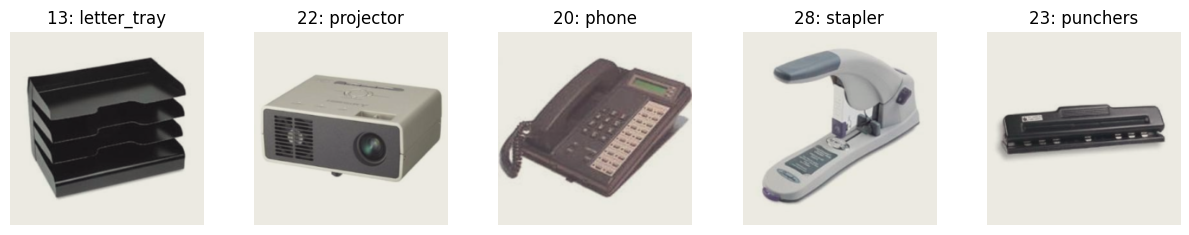

In [6]:
from clip_tuner.utils import visualize_dataset_samples

visualize_dataset_samples(source_dataset, num_samples=5)  # 带训练transform的样本
visualize_dataset_samples(target_dataset, num_samples=5)  # 验证样本

In [7]:
from clip_tuner.models import add_learnable_prompts_to_clip_text_model

model = add_learnable_prompts_to_clip_text_model(clip_model=clip_model)

model

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextLearnableEmbeddings(
      (token_embedding): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(77, 512)
      )
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Li

冻住无需训练的参数

In [8]:
# 冻住除可训练嵌入参数外的所有参数
for name, param in clip_model.named_parameters():
    param.requires_grad_(False)
    if 'learnable_embeddings' in name:
        param.requires_grad = True

# for name, param in model.named_parameters():
#     print(f"Parameter name: {name}, Requires grad: {param.requires_grad}")

In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments()

training_args.per_device_train_batch_size = 64
training_args.per_device_eval_batch_size = 64
training_args.learning_rate = 5e-5
training_args.warmup_steps = 0
training_args.weight_decay = 0.1
training_args.overwrite_output_dir = True
training_args.do_train = True
training_args.do_eval = True
training_args.remove_unused_columns = False

training_args


TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=True,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.NO,
eval_use_

处理数据，将数据集的 label 字段转换为字符串，并利用 Tokenizer 完成嵌入

In [10]:
source_dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 795
})

In [12]:
from transformers import Trainer
import torch

prompt_template = "a photo of a {}."

def label2prompt(example_batch):
    # 获取
    # print(example_batch["label"])
    prompt_with_label = [prompt_template.format(source_dataset.features["label"].int2str(label)) for label in example_batch["label"]]
    text_inputs = clip_tokenizer(prompt_with_label, return_tensors="pt", padding=True)
    example_batch["input_ids"] = text_inputs.input_ids
    example_batch["attention_mask"] = text_inputs.attention_mask
    return example_batch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    input_ids = torch.tensor(
        [example["input_ids"] for example in examples], dtype=torch.long
    )
    attention_mask = torch.tensor(
        [example["attention_mask"] for example in examples], dtype=torch.long
    )
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "return_loss": True,
    }

source_dataset = source_dataset.map(
    function=label2prompt,
    batched=True,
    desc="Running tokenizer on source dataset")

target_dataset = target_dataset.map(
    label2prompt,
    batched=True,
    desc="Running tokenizer on source dataset")

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=source_dataset if training_args.do_train else None,
    eval_dataset=target_dataset if training_args.do_eval else None,
    data_collator=collate_fn,
)

training_args.device

train_result = trainer.train()
trainer.save_model()
trainer.log_metrics("train", train_result.metrics)
trainer.save_metrics("train", train_result.metrics)
trainer.save_state()


Running tokenizer on source dataset:   0%|          | 0/795 [01:03<?, ? examples/s]


KeyboardInterrupt: 